# Init Step

## import library

In [1]:
import tensorflow as tf
import keras as K
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import os
import pathlib
import utils

## variables

In [2]:
height, width = 224, 224
fps = 4
n_classes = 9
# savePath = "./data/cropHand_fps4/"
splitedFolder = "color_fps4_splited_dataset"



# Preprocessing of images dataset

In [3]:
import os
cwd = os.getcwd()
print("current dir: {}".format(cwd))

current dir: c:\Users\mkhung6\Desktop\FYP\handGesture_FYP\model


In [4]:
# directory of the images dataset
base_dir = Path('../data')
data_dir = base_dir/ splitedFolder
train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

# variable for model parameter 
n_epochs = 11
n_train_samples = utils.count_jpgs(train_dir)
n_val_samples = utils.count_jpgs(val_dir)
batch_size = 32

In [5]:
# data augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(height,width))
val_generator = train_datagen.flow_from_directory(val_dir, target_size=(height,width))

test_datagen = ImageDataGenerator(rescale=1./255) #use the original image for testing
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(height,width))

Found 7983 images belonging to 9 classes.
Found 2663 images belonging to 9 classes.
Found 2649 images belonging to 9 classes.


In [6]:
import utils
from keras.applications import VGG16
# load pretrained model and weights
conv_layers = VGG16(weights = 'imagenet', include_top=False, input_shape=(height,width,3))
conv_layers.trainable = False
print('per-trained model has been loaded')
conv_layers.summary()



per-trained model has been loaded
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2

In [7]:
# pretraind model
model = K.models.Sequential()
model.add(conv_layers)
model.add(K.layers.Flatten())

# new layers
model.add(K.layers.Dense(256, activation='relu')) 
model.add(K.layers.Dropout(0.5)) # dropout layer to reduce overfitting
model.add(K.layers.Dense(256, activation='relu'))
model.add(K.layers.Dropout(0.5))

model.add(K.layers.Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 9)                 2

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(train_generator,
                    steps_per_epoch=n_train_samples/batch_size,
                    epochs=n_epochs,
                    validation_data=val_generator,
                    validation_steps=n_val_samples/batch_size,
                    verbose=2,
                    shuffle=True,
                    )


Epoch 1/11


249/249 - 582s - loss: 1.0738 - acc: 0.6260 - val_loss: 0.0402 - val_acc: 0.9944 - 582s/epoch - 2s/step
Epoch 2/11
249/249 - 574s - loss: 0.4546 - acc: 0.8152 - val_loss: 0.0143 - val_acc: 0.9981 - 574s/epoch - 2s/step
Epoch 3/11
249/249 - 574s - loss: 0.4182 - acc: 0.8354 - val_loss: 0.0068 - val_acc: 0.9981 - 574s/epoch - 2s/step
Epoch 4/11
249/249 - 574s - loss: 0.3555 - acc: 0.8564 - val_loss: 0.0140 - val_acc: 0.9966 - 574s/epoch - 2s/step
Epoch 5/11
249/249 - 575s - loss: 0.3737 - acc: 0.8509 - val_loss: 0.0049 - val_acc: 0.9992 - 575s/epoch - 2s/step
Epoch 6/11
249/249 - 574s - loss: 0.3517 - acc: 0.8610 - val_loss: 0.0062 - val_acc: 0.9992 - 574s/epoch - 2s/step
Epoch 7/11
249/249 - 577s - loss: 0.3411 - acc: 0.8658 - val_loss: 0.0046 - val_acc: 0.9996 - 577s/epoch - 2s/step
Epoch 8/11
249/249 - 572s - loss: 0.3423 - acc: 0.8603 - val_loss: 0.0104 - val_acc: 0.9989 - 572s/epoch - 2s/step
Epoch 9/11
249/249 - 571s - loss: 0.3291 - acc: 0.8722 - val_loss: 0.0062 - v

In [9]:
model.save(splitedFolder + ".h5")

c:\Users\mkhung6\AppData\Local\anaconda3\envs\mediapipe\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# show the accuracy of the model

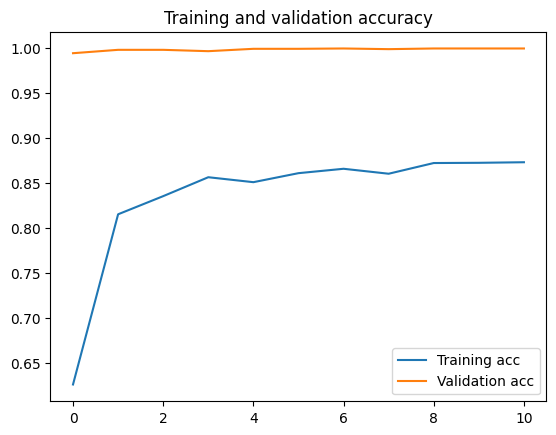

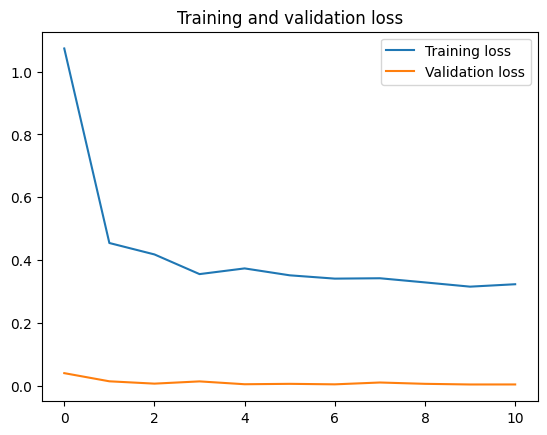

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']S
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochSs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
class_indices = train_generator.class_indices
print(class_indices)

{'ChanDingYin': 0, 'HuoYanYin': 1, 'MiTuoDingYin': 2, 'Retsu': 3, 'Rin': 4, 'TaiJiYin': 5, 'Zai': 6, 'Zen': 7, 'ZhiJiXiangYin': 8}
